# Book Success Prediction using Machine Learning

Kathryn Hamilton and Frank Shannon

w207 Spring 2018

### Introduction

The team would like to assess the relationship between the synopsis of a novel and its success by constructing a supervised machine learning classifier.

A book's synopsis, which is a couple paragraphs traditionally found on the back or inside cover of a book, serves to provide a brief explanation of the book's contents and any applicable critical acclaim of the the author. The team would like to see if this information can be used to reliably predict whether or not the book will be successful. To do this, the team will study harness information found on Amazon.com, one of the world's largest e-commerce and cloud computing companies which, fittingly, started as an online bookstore.

We begin by importing the necessary libraries and setting up our document.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import gzip
import re
import copy

np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

The data we will be using for this project come from two sources.

The first is an online repository of `.json` files compiled by Julian McAuley, Assistant Professor of Computer Science and Engineering at University of California, San Diego. These files, which can be found at http://jmcauley.ucsd.edu/data/amazon/ and will provides us with customer review information and product metadata [1, 2].

The second will be an API the team uses to scrape book synopsis data from http://www.amazon.com/ using the list of product ID numbers included in the dataset of reviews.

Prof. McAuley's papers related to the Amazon dataset are as follows:

[1] R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016

[2] J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

### Import and Clean Metadata

We first explore the datasets provided by McAuley. These files are very large so we are looking to get rid of any information that will not be useful to us.

In addition, we will want to narrow down the data into a subset that seems well suited for the purpose of this project. For starters, this means selecting a category of books (Fiction, Travel, Money & Business, etc) that has enough examples and a good range of descriptive synopses.

At this point in the project our inputs and outputs are very loosely defined. It is hard to know specifically what we data will need in the end and if we even have it to begin with. So, some upfront exploration is a good first approach to begin forming a problem that we can reasonably solve.

In [3]:
# Unpackage McAuley metadata and reviews files, which are currently compressed .json files, using the code supplied on his site.

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0 
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

Import medatadata file (or alternatively upload a saved file).

In [4]:
metadata_import = getDF('meta_Books.json.gz')

In [3]:
# Alternative
metadata = pd.read_pickle('metadata.pkl')

Let's take a look at the first few rows of the `metadata` file.

In [5]:
print "Length: ", len(metadata_import)   # print length of dataframe
metadata_import.head(n=5)   # print first 5 rows of dataframe

Length:  2370585


,asin,salesRank,imUrl,categories,title,description,related,price,brand
0,0001048791,{u'Books': 6334800},http://ecx.images-amazon.com/images/I/51MKP0T4...,[[Books]],"The Crucible: Performed by Stuart Pankin, Jero...",NaN,NaN,NaN,NaN
1,0001048775,{u'Books': 13243226},http://ecx.images-amazon.com/images/I/5166EBHD...,[[Books]],Measure for Measure: Complete &amp; Unabridged,William Shakespeare is widely regarded as the ...,NaN,NaN,NaN
2,0001048236,{u'Books': 8973864},http://ecx.images-amazon.com/images/I/51DH145C...,[[Books]],The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...","{u'also_viewed': [u'1442300191', u'9626349786'...",9.26,NaN
3,0000401048,{u'Books': 6448843},http://ecx.images-amazon.com/images/I/41bchvIf...,[[Books]],The rogue of publishers' row;: Confessions of ...,NaN,{u'also_viewed': [u'068240103X']},NaN,NaN
4,0001019880,{u'Books': 9589258},http://ecx.images-amazon.com/images/I/61LcHUdv...,[[Books]],Classic Soul Winner's New Testament Bible,NaN,"{u'also_viewed': [u'B003HMB5FC', u'0834004593'...",5.39,NaN


Let's start with the `metadata` file, which describes each book.

Immediately, we see that there are several columns that will likely be of use to us:

* `asin`, which is the unique product identification number used by Amazon.
* `salesRank`, which describes the popularity of the book within the Amazon category "Books".
* `categories`, which describes the category and sub category that the book is classified as.

There are also several columns that are not of use to us:

* `imUrl`, which is a link to the product's photo.
* `related`, which is a list of similar products.
* `brand`, which might describe affiliate companies such as the book's publisher

The first thing to do is process these fields to be the correct data type and organize the information to be suited to our project.

In [6]:
metadata = metadata_import.copy()   # create a duplicate data frame of the imported file

# convert column headers from unicode to ascii
metadata = metadata.rename(index=str,columns={u'asin':'asin', u'salesRank':'salesRank', u'imUrl':'imUrl', 
                                              u'categories':'categories', u'title':'title', u'description':'description',
                                              u'related':'related', u'price':'price', u'brand':'brand'})

metadata = metadata.drop(['imUrl','related','brand'],axis=1)   # drop unrelated columns

print "Length: ", len(metadata)   # print length of dataframe

Length:  2370585


Let's fix the syntax of the `salesRank` column so it displays as simple integer. We will set the rank to 0 for any entry that is NaN-valued, or has a ranking in a cartegory other than "Books".

In [7]:
metadata['salesRank'][metadata['salesRank'].isnull()] = 0
metadata['salesRank'] = metadata['salesRank'].astype(str)
metadata['salesRank'][~metadata['salesRank'].str.contains('Books')] = 0

metadata['salesRank'] = metadata['salesRank'].astype(str)
metadata['salesRank'] = metadata['salesRank'].str.lstrip("{'Books': ")   # strip json/unicode characters from left
metadata['salesRank'] = metadata['salesRank'].str.rstrip("}")   # strip json/unicode characters from right
metadata['salesRank'] = metadata['salesRank'].astype('int64')   # set column to be integer type

C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's take a quick look at the distribution of `salesRank`. Remember that zero-valued rankings are equivalent to `NA`.

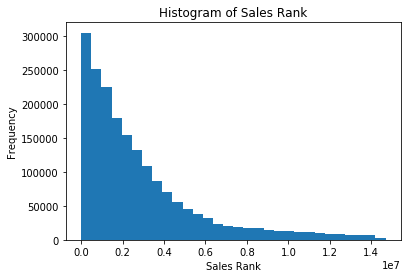

In [9]:
plt.hist(metadata['salesRank'][metadata['salesRank']!=0], bins=30)
plt.xlabel('Sales Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Sales Rank')
plt.show()

While we're at it, let's also take a look at the distribution of `price`. We see that it is roughly normal with a heavy right-skew.

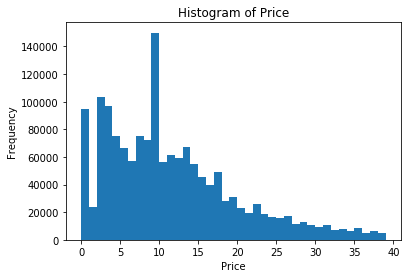

In [11]:
plt.hist(metadata['price'].dropna(axis=0), bins = range(0,40))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()

Note that this graph continues to the right quite a ways.

In [15]:
print "Maximum Price:", metadata['price'].max()
print "Minimum Price:", metadata['price'].min()
print "Mean Price:", round(metadata['price'].mean(),2)
print "Median Price:", metadata['price'].median()

Maximum Price: 999.99
Minimum Price: 0.0
Mean Price: 17.63
Median Price: 10.54


We have over two million titles to work with, which is great. Ideally we would like to narrow this down to a more workable size, likely by choosing a certain category or genre of books.

Let's check to see how many books fall into each category.

In [14]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
[['Books']],1940253
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica']]",8113
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",4060
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'Romantic Erotica']]",3189
"[['Books', 'Literature & Fiction', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction']]",3154
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'BDSM']]",3096
"[['Books', 'Reference', 'Words, Language & Grammar', 'Linguistics'], ['Kindle Store', 'Kindle eBooks', 'Reference', 'Words, Language & Grammar', 'Linguistics']]",1692
"[['Books', 'Literature & Fiction'], ['Books', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance']]",1599
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",1550


The above a table of unique categories listed in descending number of books per category. We see that 1.9 million entries are uncategorized (their category is simply `Books`). However, this still leaves about 0.5 million books that have been categorized.

We see that there is an issue here with overcategorization. For example, we see that there are several of the above rows that fall under `Literature & Fiction` but have been specified further such that in their current format these entries are not bucketed together. 

The next logical step is to roll back these classifications to a higher level (for example, change `['Books', 'Literature & Fiction', 'Contemporary']` into simply `Literature & Fiction`), and then regroup the data.

In [16]:
metadata['categories'] = metadata['categories'].astype(str)
orig_categs = metadata.categories.values   # Get a list of all categories
orig_categs = np.unique(orig_categs)   # Cut this down to only the unique categories

new_categs = copy.copy(orig_categs)   # Create a copy of this list

for i in range(0,len(new_categs)):   # For each unique category
    text = re.sub('[^a-zA-Z&, ]+', '', str(new_categs[i]))   # Remove all the extra symbols and space
    text = text.split(",")   # Split by comma
    if len(text)>1:   # If there is more than one element (category contains a sub category)
        new_categs[i] = text[1].lstrip(' ')   # New category name is the first sub category
    else:   # If there is no sub category
        new_categs[i] = 'Books'   # New category name is simply "books"

print "New, simpler categories are: \n\n", np.unique(new_categs)   # print new categories

New, simpler categories are: 

['Arts & Photography' 'Biographies & Memoirs' 'Books' 'Business & Money'
 'Calendars' 'Childrens Books' 'Christian Books & Bibles'
 'Comics & Graphic Novels' 'Computers & Technology' 'Cookbooks' 'Crafts'
 'Crafts & Sewing' 'Diapering' 'Education & Teaching'
 'Engineering & Transportation' 'Exterior Accessories' 'Gay & Lesbian'
 'Health' 'Health & Baby Care' 'History' 'Humor & Entertainment' 'Law'
 'Literature & Fiction' 'Medical Books' 'Mystery' 'New'
 'Parenting & Relationships' 'Politics & Social Sciences' 'Reference'
 'Religion & Spirituality' 'Romance' 'Science & Math'
 'Science Fiction & Fantasy' 'SelfHelp' 'Sports & Outdoors'
 'Teen & Young Adult' 'Travel']


These categories look to be at a great level for our analysis!

Now have a way to map the original categories into the list above. Some examples of this mapping are seen below.

In [19]:
pd.DataFrame(np.column_stack((orig_categs, new_categs)), columns = ("OldLabel","NewLabel")).head(n=10)

,OldLabel,NewLabel
0,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
1,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
2,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
3,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
4,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
5,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
6,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
7,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
8,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
9,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing


Let's replace the categories in the dataframe according to the mapping.

In [49]:
metadata['categories'] = metadata['categories'].astype(str)   # convert categories from objects to strings
#for i in range(0,len(orig_categs)):
for i in range(0, len(orig_categs)):
    metadata['categories'] = metadata['categories'].replace(str(orig_categs[i]), str(new_categs[i]))

We've done a lot of heavy computation so let's make sure we don't lose it.

In [46]:
metadata_backup = metadata.copy()
metadata.to_pickle('metadata.pkl')

Now let's take another look at how many examples we have in each category.

In [4]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1940253
Literature & Fiction,200791
Childrens Books,25424
Christian Books & Bibles,22470
Business & Money,18174
Biographies & Memoirs,18145
Health,18036
Cookbooks,11678
Gay & Lesbian,11533


Amazing! Now we have plenty of examples in each category.

Unfortunately, very few examples in these categories have information in the `salesRank` field. So we will not be able to reliably use the `salesRank` field.

In [5]:
metadata2 = metadata[metadata['salesRank'] != 0]
metadata2.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1890996
Health,6
Sports & Outdoors,4
Crafts,2
Reference,2
Arts & Photography,1
Childrens Books,1
Computers & Technology,1
New,1


Under further investigation we found that this was because the `salesRank` field was either empty for examples that had been categorized further than `Books`, or showed a salesRank within a subcategory of `Books` that was far too specific to reasonably unravel in the timeline of this project. So we have chosen to go ahead without using `salesRank`.

Regardless, we are now at a good place to downsize the amount of data we are working with by selecting a few categories to continue with for this project.

We are looking for categories that will have meaningful keywords in the book's description that are common across the category in general. This means we want something based in fact rather than fiction.

We also want to pick categories with enough variance that books do not tend to duplicate content and thus descriptions still contain a slightly subjective element. For example, we might run into a problem in the Reference category wherein multiple calculus textbooks might exist with virtually the same descriptions and content. Politics & Social Sciences, on the other hand, might have enough common foundational ground while still being subject to opinions and other variances.

We have decided to move forward with the following categories:

* Business & Money
* History
* Computers & Technology
* Politics & Social Sciences

In [6]:
busi = metadata[metadata['categories'] == 'Business & Money']
hist = metadata[metadata['categories'] == 'History']
tech = metadata[metadata['categories'] == 'Computers & Technology']
poli = metadata[metadata['categories'] == 'Politics & Social Sciences']

bhtp_data = pd.concat([busi,hist,tech,poli])   # Create a dataframe with all of the relevant data, to use for scraping, etc.

Let's look at a few rows of the dataframe to get reacquainted with where we are.

In [7]:
bhtp_data.head(n=5)   # print first 5 rows of dataframe

,asin,salesRank,categories,title,description,price
962599,0976963094,0,Business & Money,Dave Ramsey's ACT Your Wage! Board Game,Get gazelle intense with this new board game f...,20.27
1769347,9810579357,0,Business & Money,The Art and Science of Entrepreneurship,"In the Art and Science of Entrepreneurship, In...",NaN
1775923,B0000547EU,0,Business & Money,NaN,Known as the father of contemporary negotiatin...,NaN
1775933,B00005MCQC,0,Business & Money,NaN,NaN,NaN
1775934,B00005MB6I,0,Business & Money,NaN,NaN,NaN


### Import and Clean Review Data

Now let's turn our attention to the other dataset provided by McAuley. This set contains over 22 million star rating tuples for the same books referenced in the `metadata` dataset. This set has already been cleaned and deduplicated.

In [ ]:
reviews_import = pd.read_csv('ratings_Books.csv', names = ['user','asin','rating','timestamp'])

In [7]:
print "Length: ", len(reviews_import)   # print length of dataframe
reviews_import.head(n=5)   # print first 5 rows of dataframe

Length:  22507155


,user,asin,rating,timestamp
0,AH2L9G3DQHHAJ,0000000116,4.0,1019865600
1,A2IIIDRK3PRRZY,0000000116,1.0,1395619200
2,A1TADCM7YWPQ8M,0000000868,4.0,1031702400
3,AWGH7V0BDOJKB,0000013714,4.0,1383177600
4,A3UTQPQPM4TQO0,0000013714,5.0,1374883200


We only need `asin` and `rating` for the purpose of this project. Additionally, we can drop all of the rows that do not reference a book in one of the four categories that we have chosen.

In [9]:
reviews = reviews_import.drop(labels = ['user','timestamp'], axis = 'columns')
reviews = reviews[reviews['asin'].isin(bhtp_data['asin'])]
print "Length: ", len(reviews)   # print length of dataframe

Length:  180125


Let's compile the ratings into a list and insert them into the `metadata` dataframe, then take a look to see what we have done so far.

In [10]:
bhtp_data = bhtp_data.reset_index(drop=True)
bhtp_data['ratings'] = np.nan
bhtp_data['ratings'] = bhtp_data['ratings'].astype(object)
for i in range(0,len(bhtp_data)):
    rev_sub = reviews[reviews['asin'] == bhtp_data.iloc[i]['asin']]
    revs = np.asarray(rev_sub['rating'])
    bhtp_data.set_value(i,'ratings', revs)

In [13]:
bhtp_data.to_pickle('bhtp_data.pkl')
bhtp_data.head(n=10)

,asin,salesRank,categories,title,description,price,ratings
0,0976963094,0,Business & Money,Dave Ramsey's ACT Your Wage! Board Game,Get gazelle intense with this new board game f...,20.27,"[4.0, 4.0, 5.0, 2.0, 5.0, 4.0, 5.0, 5.0, 5.0, ..."
1,9810579357,0,Business & Money,The Art and Science of Entrepreneurship,"In the Art and Science of Entrepreneurship, In...",NaN,[5.0]
2,B0000547EU,0,Business & Money,NaN,Known as the father of contemporary negotiatin...,NaN,[5.0]
3,B00005MCQC,0,Business & Money,NaN,NaN,NaN,"[4.0, 4.0, 3.0]"
4,B00005MB6I,0,Business & Money,NaN,NaN,NaN,"[1.0, 5.0]"
5,B00005MB8F,0,Business & Money,NaN,NaN,NaN,"[1.0, 1.0]"
6,B00005MB9S,0,Business & Money,NaN,NaN,NaN,[1.0]
7,B00005MFBG,0,Business & Money,NaN,NaN,NaN,"[1.0, 1.0]"
8,B00005MFAJ,0,Business & Money,NaN,NaN,NaN,[1.0]
9,B00005N9CI,0,Business & Money,NaN,Darrell Rigby is a Director in the Boston offi...,NaN,"[4.0, 4.0, 1.0]"


Note that there are quite a few books that contain only one or two ratings. If possible, it might be wise to remove these books from consideration.

This may skew the results, as poor ratings are correlated with poor readership (people tend not to buy books with poor ratings and thus there are less people available to rate them). However, as `rating` will be one of the most important variables determining success, the risk may be worth the extra information gained by requiring a minimum number of ratings.

Alternatively, the team could use both "rating" and the "number of ratings" as variables in the analysis. This might allow for error to be attributed where the number of ratings are low.

Regardless, the team is also limited by how many examples are available with a minimum number of ratings.

In [27]:
print "Number of examples in each category that have a minimum number of ratings:\n"
bhtp_nums = bhtp_data.drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()
bhtp_nums.columns = ['All']
bhtp_nums['> 0'] = bhtp_data[bhtp_data['ratings'].str.len() > 0].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 1'] = bhtp_data[bhtp_data['ratings'].str.len() > 1].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 2'] = bhtp_data[bhtp_data['ratings'].str.len() > 2].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 3'] = bhtp_data[bhtp_data['ratings'].str.len() > 3].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 4'] = bhtp_data[bhtp_data['ratings'].str.len() > 4].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 5'] = bhtp_data[bhtp_data['ratings'].str.len() > 5].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 6'] = bhtp_data[bhtp_data['ratings'].str.len() > 6].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 7'] = bhtp_data[bhtp_data['ratings'].str.len() > 7].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 8'] = bhtp_data[bhtp_data['ratings'].str.len() > 8].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 9'] = bhtp_data[bhtp_data['ratings'].str.len() > 9].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 10'] = bhtp_data[bhtp_data['ratings'].str.len() > 10].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 11'] = bhtp_data[bhtp_data['ratings'].str.len() > 11].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 12'] = bhtp_data[bhtp_data['ratings'].str.len() > 12].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 13'] = bhtp_data[bhtp_data['ratings'].str.len() > 13].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 14'] = bhtp_data[bhtp_data['ratings'].str.len() > 14].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
print bhtp_nums

Number of examples in each category that have a minimum number of ratings:

                              All    > 0    > 1   > 2   > 3   > 4   > 5   > 6  \
categories                                                                      
Business & Money            18174  18048  10838  7739  6040  4891  4057  3448   
Computers & Technology       5031   4995   3086  2142  1592  1255  1051   901   
History                     10539  10370   4644  2810  1933  1476  1165   934   
Politics & Social Sciences   4595   4534   2093  1314   926   714   575   483   

                             > 7   > 8   > 9  > 10  > 11  > 12  > 13  > 14  
categories                                                                  
Business & Money            2986  2588  2278  1991  1757  1578  1411  1267  
Computers & Technology       789   699   619   551   494   454   417   387  
History                      795   691   608   542   486   454   407   367  
Politics & Social Sciences   418   358   318   276  

So it looks like there is a fair amount of data to work with.

It might be interesting to explore the impact of having many vs few ratings on the accuracy of the learning algorithms, even if requiring more ratings decreases the sample size.

Additionally, to allow for consistency across the categories that have been selected, the team will need to extract a subset from each such that the sample size for each category is consistent. These sets will then be partitioned into development, training, and test sets.

Hence, the team has decided to move forward with two different datasets:

* "`Many`" - 1250 examples with at least 3 ratings from each of the four categories
* "`Few`" - 300 examples with at least 10 ratings from each of the four categories

Note that this selection is mostly arbitrary. At face value, though, it seems to be well suited for exploring the relationship between total examples and minimum number of ratings, while still providing a sufficient amount of each.

In [42]:
# Pull out the Many dataset and then randomly select 1250 of each category
bhtp_many = bhtp_data[bhtp_data['ratings'].str.len() > 2]

busi_many = bhtp_many[bhtp_data['categories'] == 'Business & Money'].sample(n = 1250)
hist_many = bhtp_many[bhtp_many['categories'] == 'History'].sample(n = 1250)
tech_many = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'].sample(n = 1250)
poli_many = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'].sample(n = 1250)

bhtp_many = pd.concat([busi_many, hist_many, tech_many, poli_many])
bhtp_many = bhtp_many.reset_index(drop=True)

# Pull out the Few dataset and then randomly select 300 of each category
bhtp_few = bhtp_data[bhtp_data['ratings'].str.len() > 9]

busi_few = bhtp_few[bhtp_few['categories'] == 'Business & Money'].sample(n = 300)
hist_few = bhtp_few[bhtp_few['categories'] == 'History'].sample(n = 300)
tech_few = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'].sample(n = 300)
poli_few = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'].sample(n = 300)

bhtp_few = pd.concat([busi_few, hist_few, tech_few, poli_few])
bhtp_few = bhtp_few.reset_index(drop=True)

## -----EVERYTHING IS GOOD ABOVE HERE-----

### Scrape Description Data

In [43]:
# Save the dataframes and asin series of each so that we can use externally to scrape
bhtp_many.to_pickle('bhtp_scrape_many.pkl')
bhtp_many['asin'].to_csv('asin_scrape_many.csv')

bhtp_few.to_pickle('bhtp_scrape_few.pkl')
bhtp_few['asin'].to_csv('asin_scrape_few.csv')

At this point, I am waiting on Frank to use the list of ASINs I have provided to scrape a description from Amazon.

Until he can provide that to me, I am going to proceed with a very small subset of data, 50 examples from the Business & Money category, that I scraped by hand into a csv file.

### Machine Learning

I manually scraped information from fifty business books from the `bhtp_few` dataset.

If you don't have any local variables, you can start here and follow along.

In [161]:
bhtp_data = pd.read_pickle('bhtp_data.pkl')   # Upload the bhtp_data file if we no longer have it locally on this kernel
fifty_busi = pd.read_csv('asin_scrape_few_50.csv')   # Upload the manually scraped information

In [162]:
# Resample the dataset to create busi_few again (seed was set above) if we no longer have it locally on this kernel
bhtp_few = bhtp_data[bhtp_data['ratings'].str.len() > 9]
busi_few = bhtp_few[bhtp_few['categories'] == 'Business & Money'].sample(n = 300)

In [163]:
# Here is the information I manually scraped
fifty_busi

,index,asin,url,title,price,description
0,0,B007EP3Z3I,https://www.amazon.com/dp/B007EP3Z3I,The Winning Way,16.50,"What do sporting champions do, what makes winn..."
1,1,B007G0IVW6,https://www.amazon.com/dp/B007G0IVW6,The Golden Rule of Leadership - Why Some Peopl...,6.97,Everyone knows the Golden Rule: treat others a...
2,2,B00I2F190U,https://www.amazon.com/dp/B00I2F190U,How to Self-Promote without Being a Jerk,4.95,"You want more career success, but you don't li..."
3,3,B008Z5U4LC,https://www.amazon.com/dp/B008Z5U4LC,Publish with a Purpose: EPublishing done right...,6.87,ePublishing - Publish with a Purpose is an ama...
4,4,B00KAG2RH8,https://www.amazon.com/dp/B00KAG2RH8,76 Free Things to Do with Kids: A Real Mom's G...,2.99,Keep your kids busy all year long with these 7...
5,5,B00JCZSRXG,https://www.amazon.com/dp/B00JCZSRXG,Sell More Books: 55 Free Promotions That Work ...,2.99,Sell More Fiction or Non-Fiction Books\nNEWLY ...
6,6,B00CY19CVQ,https://www.amazon.com/dp/B00CY19CVQ,"SHEIFGAB! Staying Sane, Motivated and Producti...",2.99,Irishman Finbarr Kozlowski (honest!) is visiti...
7,7,B00CQ9UJHM,https://www.amazon.com/dp/B00CQ9UJHM,The Million Dollar Business Coaching Firm: The...,9.99,How a Broke Ex-Pastor Built a Business Coachin...
8,8,B00I92G4J2,https://www.amazon.com/dp/B00I92G4J2,Time Management Unlimited: Organize Your Life ...,2.99,How Much Money Is Your Company Losing In Faile...
9,9,B00BEJC9AK,https://www.amazon.com/dp/B00BEJC9AK,How To Quickly Get Started As A Personal Coach...,14.95,Right now there are millions of people that ne...


Now we need to do a bit of work to merge the two dataframe together and reduce down to the columns that we will actually use.

In [164]:
fifty_busi = pd.merge(fifty_busi, bhtp_data, on="asin")
fifty_busi = fifty_busi.drop(['index','url','salesRank','title_y','description_y','price_y'], axis = 1)
fifty_busi = fifty_busi.rename(index=str,columns={'title_x':'title', 'price_x':'price', 'description_x':'description'})
fifty_busi = fifty_busi.dropna(axis=0)
fifty_busi = fifty_busi.reindex()

In [165]:
fifty_busi

,asin,title,price,description,categories,ratings
0,B007EP3Z3I,The Winning Way,16.50,"What do sporting champions do, what makes winn...",Business & Money,"[5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, ..."
1,B007G0IVW6,The Golden Rule of Leadership - Why Some Peopl...,6.97,Everyone knows the Golden Rule: treat others a...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,B00I2F190U,How to Self-Promote without Being a Jerk,4.95,"You want more career success, but you don't li...",Business & Money,"[4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, ..."
3,B008Z5U4LC,Publish with a Purpose: EPublishing done right...,6.87,ePublishing - Publish with a Purpose is an ama...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ..."
4,B00KAG2RH8,76 Free Things to Do with Kids: A Real Mom's G...,2.99,Keep your kids busy all year long with these 7...,Business & Money,"[1.0, 5.0, 3.0, 3.0, 5.0, 4.0, 3.0, 5.0, 4.0, ..."
5,B00JCZSRXG,Sell More Books: 55 Free Promotions That Work ...,2.99,Sell More Fiction or Non-Fiction Books\nNEWLY ...,Business & Money,"[3.0, 4.0, 3.0, 5.0, 4.0, 4.0, 3.0, 4.0, 3.0, ..."
6,B00CY19CVQ,"SHEIFGAB! Staying Sane, Motivated and Producti...",2.99,Irishman Finbarr Kozlowski (honest!) is visiti...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, ..."
7,B00CQ9UJHM,The Million Dollar Business Coaching Firm: The...,9.99,How a Broke Ex-Pastor Built a Business Coachin...,Business & Money,"[5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 3.0, 5.0, ..."
8,B00I92G4J2,Time Management Unlimited: Organize Your Life ...,2.99,How Much Money Is Your Company Losing In Faile...,Business & Money,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
9,B00BEJC9AK,How To Quickly Get Started As A Personal Coach...,14.95,Right now there are millions of people that ne...,Business & Money,"[3.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 3.0, 5.0, ..."


Great! So now we have some data to work with.

Okay, so we want to do some machine learning. Let's first talk a bit about what we want to achieve.

The purpose of this investigation is to explore the relationship between book jacket description and book success. While there are many factors that go into a person deciding to purchase a book, such as word of mouth recommendations, cover art, and notability of the author, we want to focus on book jacket descriptions in particular.

Suppose someone is in a bookstore browing books or surfing through Amazon. They read the book jacket description to get a feel for what the contents of the book will be, any critical acclaim of the author, and perhaps, in the case of Business & Money books for example, how the book might impact the reader's daily livelihood.

It is reasonable to assume that given a particular category of books there might be certain keywords or phrases included in a book jacket description that might entice a prosepective reader to buy it.

While we don't have sales information to work with, we do have rating information. Ratings and sales do share their own relationship, as people tend not to buy products that are rated poorly. However, it might also make sense that poorly writen books that recieve poor reviews also have poorly written book jacket descriptions, and vice versa.

So operationally, let's set our first goal at predicting five-star rating using book jacket text.

To create a list of classes, let's make a new column that has the rounded average star rating.

In [166]:
fifty_train = np.copy(np.asarray(fifty_busi['description'][0:40]))
fifty_dev = np.copy(np.asarray(fifty_busi['description'][40:45]))
fifty_test = np.copy(np.asarray(fifty_busi['description'][45:50]))
print len(fifty_train), len(fifty_dev), len(fifty_test)

40 5 5


In [167]:
avg_ratings = []
for i in range(0,len(fifty_busi)):
    avg_ratings.append(round(np.mean(fifty_busi['ratings'][i])))
 
fifty_busi['rate'] = avg_ratings

In [168]:
fifty_busi.drop(['title','price','description','categories','ratings'], axis = 1).groupby('rate').count()

,asin
rate,
2.0,1
3.0,1
4.0,20
5.0,29


Note that we only have one example each of 2 and 3 star books so these categories will be relatively useless for now.

In [169]:
# Our classes are as follows
classes = ['0.0','1.0','2.0','3.0','4.0','5.0']

Now partition into a few datasets. We are working with very limited data here. Let's use an 80:10:10 split.

Let's take a look at an example of a book jacket description.

In [170]:
print '-------------------------------------------------------------'
print fifty_train[5]
print '-------------------------------------------------------------'

-------------------------------------------------------------
Sell More Fiction or Non-Fiction Books
NEWLY REVISED, UPDATED AND EXPANDED

Thanks to reader feedback, we have recently added more than 5,000 words to this book, expanded coverage of marketing basics and added five new promotional methods.

What's the secret to selling more indie and self-published books on the Kindle platform?
It all starts with a great book - but after that, success hinges on your ability to effectively promote what you've written. For a few authors, promotion is easy. For most, it's not only a labyrinth of confusing pathways, it's also a huge time-suck. 

In Sell More Books: 55 Free Promotions That Work, you'll learn how to focus on the promotional methods that fit both your personality and your genre.

Boost Your Book Sales to New Levels
If you're like a lot of authors, your book is getting good reviews but only selling a copy or two a day, if that. One of the reasons for static sales is the reality that

Immediately I see a few phrases that might catch my eyes as a prospective buy. Here are a few examples:

* "NEWLY REVISED, UPDATED AND EXPANDED"
* "Plus, we've included a cool bonus that we know you'll enjoy!"

We want to see if phrases like this help predict success.

First, though, we need to do a bit of clean up to break this text down. Our preprocessor of choice will remove everything except letters and numbers. I will also make everything lower case and remove unnecessary spaces and line breaks.

In [171]:
for i in range(0,len(fifty_train)):   # for each training example
    text = fifty_train[i]   # pull the descpription text
    text = re.sub("\n", " ", text)   # replace new lines with spaces
    text = re.sub("[^a-zA-Z0-9 ]","", text).lower()   # remove everything except letters and numbers, then change to lower case
    text = re.sub(" +"," ", text)   # remove excessive white space
    text.decode("utf-8", "ignore").encode("ascii","ignore")   # deal with encoding issues
    fifty_train[i] = text   # store clean text back into array
    
for i in range(0,len(fifty_dev)):   # for each training example
    text = fifty_dev[i]   # pull the descpription text
    text = re.sub("\n", " ", text)   # replace new lines with spaces
    text = re.sub("[^a-zA-Z0-9 ]","", text).lower()   # remove everything except letters and numbers, then change to lower case
    text = re.sub(" +"," ", text)   # remove excessive white space
    text.decode("utf-8", "ignore").encode("ascii","ignore")   # deal with encoding issues
    fifty_dev[i] = text   # store clean text back into array
    
for i in range(0,len(fifty_test)):   # for each training example
    text = fifty_test[i]   # pull the descpription text
    text = re.sub("\n", " ", text)   # replace new lines with spaces
    text = re.sub("[^a-zA-Z0-9 ]","", text).lower()   # remove everything except letters and numbers, then change to lower case
    text = re.sub(" +"," ", text)   # remove excessive white space
    text.decode("utf-8", "ignore").encode("ascii","ignore")   # deal with encoding issues
    fifty_test[i] = text   # store clean text back into array

Let's take a look at the cleaned up version.

In [172]:
print fifty_train[5]

sell more fiction or nonfiction books newly revised updated and expanded thanks to reader feedback we have recently added more than 5000 words to this book expanded coverage of marketing basics and added five new promotional methods whats the secret to selling more indie and selfpublished books on the kindle platform it all starts with a great book but after that success hinges on your ability to effectively promote what youve written for a few authors promotion is easy for most its not only a labyrinth of confusing pathways its also a huge timesuck in sell more books 55 free promotions that work youll learn how to focus on the promotional methods that fit both your personality and your genre boost your book sales to new levels if youre like a lot of authors your book is getting good reviews but only selling a copy or two a day if that one of the reasons for static sales is the reality that competition between kindle indie authors is high and getting higher what makes one author more s

Awesome! So now we have just the words and no punctionation or extra characters.

From here, I'm going to start with some exploration loosely based on wahat we accomplished in Project 2. We start with exploring a Count Vectorizer, which converts text into word count vectors.

In [173]:
cv = CountVectorizer()   # initialize a count vectorizer
train_vec = cv.fit_transform(fifty_train)   # fit an transform training data

print "Size of vocabulary:", len(cv.vocabulary_)   # print length of resulting vocabulary
[n,m] = train_vec.shape   # extract shape of feature vector matrix
print "Average non-zero features per example:", train_vec.nnz/n   # total non-zero entries / total examples (rows)
print "Fraction of non-zero entries:", train_vec.nnz/(n*m)   # total non-zero entires / total entries

cv_names = cv.get_feature_names()   # get list of feature names
# print first and last feature names
print "\nFirst and last feature names:", cv_names[0], "and", cv_names[len(cv_names)-1]

cv_bigram = CountVectorizer(ngram_range = (2,2), analyzer = 'word')   # initialize bigram vectorizer
cv_bigram.fit(fifty_train)   # fit using training data
print "\nSize of bigram vocabulary:", len(cv_bigram.vocabulary_)   # print length of resulting vocabulary

cv_trigram = CountVectorizer(ngram_range = (3,3), analyzer = 'word')   # initialize trigram vectorizer
cv_trigram.fit(fifty_train)   # fit using training data
print "Size of trigram vocabulary:", len(cv_trigram.vocabulary_)   # print length of resulting vocabulary

cv_10 = CountVectorizer(min_df = 10)   # initialize vectorizer that ignores frequencies less than 10
cv_10.fit(fifty_train)   # fit using training data
print "\nVocabulary length ignoring frequencies less than 10:", len(cv_10.vocabulary_)

cv_train = CountVectorizer()   # initialize a count vectorizer
cv_train.fit(fifty_train)   # fit an transform training data
train_vocab = cv_train.vocabulary_   # pull out vocabulary
print "\nSize of training vocabulary:", len(train_vocab)

cv_dev = CountVectorizer()   # initialize a count vectorizer
cv_dev.fit(fifty_dev)   # fit an transform training data
dev_vocab = cv_dev.vocabulary_   # pull out vocabulary
print "Size of dev vocabulary:", len(dev_vocab)

missing_items = []   # make an empty list for missing items
for item in fifty_dev:   # for each word in dev vocabulary
    if not(train_vocab.has_key(item)):   # if the word is not part of training vocabulary
        missing_items.append(item)   # append to missing items list
print "Number of dev words missing from the training vocabulary:", len(missing_items)   # print number of missing items

Size of vocabulary: 2293
Average non-zero features per example: 139
Fraction of non-zero entries: 0

First and last feature names: 099 and zero

Size of bigram vocabulary: 7567
Size of trigram vocabulary: 9370

Vocabulary length ignoring frequencies less than 10: 93

Size of training vocabulary: 2293
Size of dev vocabulary: 506
Number of dev words missing from the training vocabulary: 5


It looks like we have a reasonable vocabulary given the size of the dataset. Notably, there are over 93 words that have a frequency of at least 10! We also see that almost all of the dev words are included in the training vocabulary, which is great.

Now let's briefly compare some classifiers.

In [174]:
# Pull train labels (rounded average rating: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0)
train_labels = np.asarray(fifty_busi['rate'][0:40])
dev_labels = np.asarray(fifty_busi['rate'][40:45])
test_labels = np.asarray(fifty_busi['rate'][45:50])

In [175]:
cv = CountVectorizer()
train_vec = cv.fit_transform(fifty_train)   # fit and transform training data
dev_vec = cv.transform(fifty_dev)   # transform dev data

## KNN CLASSIFIER

accuracies = []   # create empty list to store accuracies for comparison
neighbors = [1,2,3,4,5,6,7,8,9,10]   # some neighbor values that seem plausible
for k in neighbors:   # for each number of neighbors
    knn = KNeighborsClassifier(n_neighbors = k)   # initialize nearest neighbors classifier with k neighbors
    knn.fit(train_vec, train_labels)   # fit using training data and labels
    dev_pred = knn.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(dev_labels, dev_pred,average='micro'))   # append accuracy to list

k_opt = neighbors[accuracies.index(max(accuracies))]   # find optimal neighbors
# print optimal neighbors and corresponding accuracy
print "The optimal knn classifier uses k =", k_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy."

## MULTINOMIAL NAIVE BAYES CLASSIFIER

accuracies = []   # create empty list to store accuracies for comparison
alphas = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1]   # some alpha values that seem plausible
for k in alphas:   # for each value of alpha
    mnb = MultinomialNB(alpha = k)   # initialize multinomial bayes classifier with alpha = k
    mnb.fit(train_vec, train_labels)   # fit using training data and labels
    dev_pred = mnb.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(dev_labels, dev_pred,average='micro'))   # append accuracy to list

a_opt = float(alphas[accuracies.index(max(accuracies))])   # find optimal alpha
# print optimal alpha and corresponding accuracy
print "\nThe optimal mnb classifier uses a =", a_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy.\n"

## LOGISTIC REGRESSION

accuracies = []   # create empty list to store accuracies for comparison
Cs = [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,1]   # some C values that seem plausible
for k in Cs:   # for each value of C
    lr = LogisticRegression(C = k)   # initialize a logistic regression classifier with C = k
    lr.fit(train_vec, train_labels)   # fot using training data and labels
    dev_pred = lr.predict(dev_vec)   # predict dev labels
    accuracies.append(metrics.f1_score(dev_labels, dev_pred,average='micro'))   # append accuracy to list

c_opt = Cs[accuracies.index(max(accuracies))]   # find optimal C
# print optimal C and corresponding accuracy
print "The optimal lr classifier uses c =", c_opt, "resulting in", round(accuracies[accuracies.index(max(accuracies))],4), "accuracy."

The optimal knn classifier uses k = 1 resulting in 0.8 accuracy.

The optimal mnb classifier uses a = 0.0001 resulting in 0.8 accuracy.

The optimal lr classifier uses c = 0.0001 resulting in 0.6 accuracy.


Keep in mind that because the development set only has five examples, we are limited to accuracies of 0.0, 0.2, 0.4, 0.6, 0.8, or 1.0.

Surprisingly, all three of these classifiers look like they performed decently well! 

Interestingly, the Nearest Neighbors classifier only wanted to use one neighbor. This might be a result of the code, as it could be that every number of neighbors tested resulted in a 0.8 accuracy, and so the simplest classifier, which uses k=1, was selected. 

In theory, however, nearest neighbors probably won't work too well for this project because the training examples are very sparse. Right now, it looks like the classifier is just trying to match a book to its most similar competitor and rank it based on the competitor's ranking, which is a decent approach. If we were to have more examples, we might find that the classifier would try to use many neighbors in an attempt to reduce noise. However, even if we were to have several thousand examples to work with, we are not likely to have enough examples to allow for substantial similarity between an example and its neighbors. This classifier might be improved by increasing the amount of training data or preprocessing the training and dev data to ensure examples are less sparse in the space of all possible examples. A nearest neighbors classifier might be best suited for the Reference category, for example comparing very similar mathematics textbooks on the same subject, as a dataset like that would be relatively dense.

The Multinomial Bayes and Logisitic Regression classifiers used the minimal alpha and c values, respectively. Again, this is likely a result of the code and limitation in number of examples, as every alpha and c value might have produced the same accuracy, resulting in the code returning the value that was first tests.

In theory, we know that Naive Bayes and Logistic Regression both use the same "hypthesis space", but operate with different loss functions. Naive Bayes considers marginal likelihoods in addition to conditional likelihoods, where as logistic regression considers just conditional likelihood and therefore does not know joint density. This means that Naive Bayes probably works best here, even though there is relatively little training data. Logistic regression is more likely to be overfit.

In [176]:
print "Classes:", lr.classes_


Classes: [ 2.  3.  4.  5.]


Our examples only contain four separate five-star classes. We do not have any book title with 0 or 1 star on average.

Proceeding with Logistic Regression, let's take a look at the features with the largest weights for each label for both a unigram and bigram vectorizer.

In [177]:
print "\nUsing a simple vectorizer:\n"

cv = CountVectorizer()   # initialize a count vectorizer
train_vec = cv.fit_transform(fifty_train)   # fit and transform training data
dev_vec = cv.transform(fifty_dev)   # transform dev data

lr = LogisticRegression()   # initialize a logistic regression classifier
lr.fit(train_vec, train_labels)   # fit using training data

result = np.zeros((20,4))   # create an empty matrix to store 20 largest features
index = []   # create empty array to store index values of 20 largest features
for i in range(0,4):   # for each label
    temp = lr.coef_[i,:]   # get the corresponding array of weights
    temp2 = (-temp).argsort()[:5]   # get index of 5 largest values
    for j in temp2:   # append indeces to array
        index.append(j)

for i in range(0,20):   # for each row and column of matrix
    for j in range(0,4):
        result[i,j] = round(lr.coef_[j,index[i]],3)   # pull and save weight value using index array

print "\t\t\t   2.0    3.0    4.0    5.0"
print "\t\t\t   2.0"
for i in range(0,len(index)):
    if i == 5:
        print "\t\t\t          3.0"
    if i == 10:
        print "\t\t\t                 4.0"
    if i == 15:
        print "\t\t\t                        5.0"
    if i in [0,1,4,6,7,8,10,15,18]:
        print cv.vocabulary_.keys()[index[i]], "\t\t\t", result[i,:]
    else:
        print cv.vocabulary_.keys()[index[i]], "\t\t", result[i,:]  

## USING BIGRAM VECTORIZER

print "\n\nUsing a bigram vectorizer:\n"

cv_bigram = CountVectorizer(ngram_range = (2,2), analyzer = 'word')   # initialize bigram vectorizer
train_vec_bigram = cv_bigram.fit_transform(fifty_train)   # fit and transform training data
dev_vec_bigram = cv_bigram.transform(fifty_dev)   # transform dev data

lr = LogisticRegression()   # initialize a logistic regression classifier
lr.fit(train_vec_bigram, train_labels)   # fit using (bigram) training data

result = np.zeros((20,4))   # create an empty matrix to store 20 largest features
index = []   # create empty array to store index values of 20 largest features
for i in range(0,4):   # for each label
    temp = lr.coef_[i,:]   # get the corresponding array of weights
    temp2 = (-temp).argsort()[:5]   # get index of 5 largest values
    for j in temp2:   # append indeces to array
        index.append(j)

for i in range(0,20):   # for each row and column of matrix
    for j in range(0,4):
        result[i,j] = round(lr.coef_[j,index[i]],3)   # pull and save weight value using index array
        
print "\t\t\t   2.0    3.0    4.0    5.0"        
print "\t\t\t   2.0"
for i in range(0,len(index)):
    if i == 5:
        print "\t\t\t          3.0"
    if i == 10:
        print "\t\t\t                 4.0"
    if i == 15:
        print "\t\t\t                        5.0"
    if i == 13:
        print cv_bigram.vocabulary_.keys()[index[i]], "\t", result[i,:]
    else:
        print cv_bigram.vocabulary_.keys()[index[i]], "\t\t", result[i,:]


Using a simple vectorizer:

			   2.0    3.0    4.0    5.0
			   2.0
video 			[ 0.126 -0.045 -0.057 -0.088]
once 			[ 0.126 -0.045 -0.068 -0.072]
occupation 		[ 0.126 -0.045 -0.074 -0.065]
arriving 		[ 0.126 -0.019 -0.095 -0.056]
where 			[ 0.123 -0.051 -0.028 -0.099]
			          3.0
networking 		[-0.03   0.282 -0.059 -0.062]
15 			[-0.     0.136 -0.014 -0.055]
150000 			[-0.     0.081 -0.001 -0.033]
wider 			[-0.001  0.077 -0.079  0.052]
professional 		[-0.004  0.072 -0.043  0.035]
			                 4.0
mr 			[-0.117 -0.129  0.209 -0.156]
obstacles 		[-0.179 -0.174  0.208 -0.203]
security 		[-0.175 -0.169  0.205 -0.203]
friends 		[-0.102 -0.117  0.202 -0.067]
operating 		[-0.107 -0.108  0.201 -0.178]
			                        5.0
put 			[-0.153 -0.171 -0.223  0.238]
lessons 		[-0.042 -0.053 -0.157  0.207]
correctly 		[-0.133 -0.143 -0.182  0.189]
versus 			[-0.068 -0.052 -0.151  0.184]
demanding 		[-0.058 -0.04  -0.167  0.183]


Using a bigram vectorizer:

			   2.0    3.0    4.0

Recall that we only have one example each for 2 and 3 star books, so these classes are relatively useless for now.

Looking at 4 and 5 star books, there's not a heck of a lot that is discernable from this information as far as I can tell. Definitely no hint at "New York Times Bestseller" or similar. It would be interesting to run this with more examples to see what the results are.

In the unigram/simple vectorizer we see that "mr" is an important word for 4.0 star books. This would suggest an author or related person of authority that one addresses as a Mister. It appears that 5.0 star books are likely to include "lessons" and provide "demanding" content. The bigram vectorizer is less conclusive.

Let's look next at how the L1 and L2 norms compare when using Logistic Regression.

In [178]:
cv = CountVectorizer()   # initialize count vectorizer
train_vec = cv.fit_transform(fifty_train)   # fit and transform training data
dev_vec = cv.transform(fifty_dev)   # predict dev labels

lr1 = LogisticRegression(penalty='l1')   # initialize L1 logistic regression classifier
lr1.fit(train_vec, train_labels)   # fit using training data and labels
(n,m) = lr1.coef_.shape   # get shape of weights matrix
i = 0   # initialize count of non-zero weights
indeces_l1 = []   # initialize array to keep track of features with all zero weights
for j in range(0,m):   # for all features
    nz = 0   # used to indicate whether a non-zero weight is found
    for k in range(0,n):   # for all classes
        if round(lr1.coef_[k,j],5) != 0:   # if rounded value is non-zero
            i = i + 1   # increment counter
            nz = 1   # flag that this feature has at least one non-zero weight
    if nz == 0:   # if feature did not have at least one non-zero weight
        indeces_l1.append(j)   # append index to array
print "L1: there are", i, "non-zero weights out of", n*m, "total."
print m-len(indeces_l1), "out of", m, "features have at least one non-zero value."

lr2 = LogisticRegression(penalty='l2')   # initialize L2 logistic regression classifier
lr2.fit(train_vec, train_labels)   # fit using training data and labels
dev_pred = lr2.predict(dev_vec)   # predict dev labels
(n,m) = lr2.coef_.shape   # get shape of weights matrix
i = 0   # initialize count of non-zero weights
indeces_l2 = []   # initialize array to keep track of features with all zero weights
for j in range(0,m):   # for all features
    nz = 0   # used to indicate whether a non-zero weight is found
    for k in range(0,n):   # for all classes
        if round(lr2.coef_[k,j],5) != 0:   # if rounded value is non-zero
            i = i + 1   # increment counter
            nz = 1   # flag that this feature has at least one non-zero weight
    if nz == 0:   # if feature did not have at least one non-zero weight
        indeces_l2.append(j)   # append index to array
print "\nL2: there are", i, "non-zero weights out of", n*m, "total."
print m-len(indeces_l2), "out of", m, "features have at least one non-zero value."

L1: there are 62 non-zero weights out of 9172 total.
37 out of 2293 features have at least one non-zero value.

L2: there are 7963 non-zero weights out of 9172 total.
2293 out of 2293 features have at least one non-zero value.


We defined "non-zero" as greater than 0.00001.

The L1 norm has a large percentage of feature that are zero valued. This means that we could reduce the vocabulary substationally by only including those feature that have at least one non-zero value.

On the other hand, every feature in the L2 norm regression has at least one non-zero value so it cannot be reduced in this way.

Let's try using the vocabulary decreased by the L1 norm in a new L2 Logistic Regression

In [179]:
reduced_vocab = cv.vocabulary_   # get full vocabulary
k = reduced_vocab.keys()   # get list of vocabulary keys
for i in indeces_l2:   # for each index (feature that has all zero weights)
    del reduced_vocab[k[i]]   # delete the words from the vocabulary

# My vocabulary values are not a continuous sequence so I will need to renumber them
v = 0   # initialize counter to rewrite vocabulary values
for key, value in reduced_vocab.items():   # for each entry in the vocabulary
    reduced_vocab[key] = v   # rewrite write the value to be incrementing
    v = v + 1   # increment counter

cv = CountVectorizer(vocabulary = reduced_vocab)   # initialize count vectorizer with reduced vocabulary
train_vec = cv.fit_transform(fifty_train)   # fit and transform training data
dev_vec = cv.transform(fifty_dev)   # transform dev data

lr = LogisticRegression(penalty = 'l2')   # initialize a logistic regression classifier
lr.fit(train_vec, train_labels)   # fit using training data
dev_pred = lr.predict(dev_vec)   # predict dev data
print "Accuracy:", metrics.f1_score(dev_labels, dev_pred,average='micro')   # print accuracy

Accuracy: 0.6


The accuracy has not changed... but if we were evaluating on a larger dataset it might have.

Now let's try using a Tfidf Vectorizer. This vectorizer is similar to the count vectorizer, adds the extra step of normalizing the resulting count matrix to term frequency representation.

In [180]:
tf = TfidfVectorizer()   # initialize a Tfid Vectorizer
train_vec = tf.fit_transform(fifty_train)   # fit and transform training data
dev_vec = tf.transform(fifty_dev)   # transform dev data

lr = LogisticRegression(C = 100)   # initialize a logistic regression classifier with c=100
lr.fit(train_vec, train_labels)   # fit to training data
dev_pred = lr.predict(dev_vec)   # predict dev labels

print "Accuracy:", metrics.f1_score(dev_labels, dev_pred,average='micro')   # print accuracy

Accuracy: 0.6


It's not clear whether the Tfidf Vectorizer is making a difference either.

Let's look at a few misclassified examples.

In [181]:
prob = lr.predict_log_proba(dev_vec)   # output probability matrix
[n,m] = prob.shape   # get shape of matrix

Rs = []   # create empty list to store R values

for i in range(0,n):   # for each observation
    probs = np.exp(prob[i,:])   # get array of probabilities
    max_prob = max(probs)   # get max probability
    true_prob = probs[int(dev_labels[i])-2]   # get probability of true label
    Rs.append(float(max_prob)/true_prob)   # calculate and append R value

Rs = np.asarray(Rs)
docs = (-Rs).argsort()[:2]   # find three indeces with largest R values

for i in docs:
    print "True Type:", dev_labels[i]   # print label of data
    print "Classified as:", dev_pred[i]   # print label of data
    print "R =", round(Rs[i],4)
    print "\n", fifty_busi['description'][i], "\n\n\n"   # print data text


True Type: 4.0
Classified as: 5.0
R = 1.8753

Everyone knows the Golden Rule: treat others as you�d like to be treated. Golan�s �The Golden Rule of Leadership,� takes that premise seven times further, delving into the lives of extraordinary, historical profiles. Through essays, quotes, and anecdotal accounts of men and women ranging from Tim Burton to Clara Barton, leadership is reenacted through a wide lens of time with a sharp focus on intent, determination, self-insight, open communication, teamwork, and uncanny resourcefulness. Golan administers truth and inspiration from the first page of this book, and the resulting read is as enlightening as it is entertaining. 



True Type: 4.0
Classified as: 5.0
R = 1.238

ePublishing - Publish with a Purpose is an amazing book that teaches its readers how to use ePublishing to its maximum potential. It is all about self publishing and about getting a book published. Yes, you can now easily publish your own book. ePublishing is not just about

It's hard to know why the above have not been classified correctly based on just the descriptions. They both seem like interesting books. With more data this might be interesting to explore again for examples that have been severely misclassified, for example a 5 star book predicted to be a 2 or 3 star book.

At this point, we've taken a good look around some of the classifiers and vectorizers that we've worked with in this course. Let's reestablish where we are in terms of solving the problem before we proceed any further.

## -----Code to use when Frank has provided scraped data-----

### Partition Data

Now we are at a point where all of our data is ready for analysis. We begin by partitioning each of the four categories into three sets of data: a training set, a development set, and a test set.  

We will be using a 80:10:10 ratio between these sets.

In [50]:
busi_many_train = bhtp_many[bhtp_many['categories'] == 'Business & Money'][:1000]
busi_many_dev = bhtp_many[bhtp_many['categories'] == 'Business & Money'][1000:1125]
busi_many_test = bhtp_many[bhtp_many['categories'] == 'Business & Money'][1125:]

hist_many_train = bhtp_many[bhtp_many['categories'] == 'History'][:1000]
hist_many_dev = bhtp_many[bhtp_many['categories'] == 'History'][1000:1125]
hist_many_test = bhtp_many[bhtp_many['categories'] == 'History'][1125:]

tech_many_train = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'][:1000]
tech_many_dev = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'][1000:1125]
tech_many_test = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'][1125:]

poli_many_train = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'][:1000]
poli_many_dev = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'][1000:1125]
poli_many_test = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'][1125:]

busi_few_train = bhtp_few[bhtp_few['categories'] == 'Business & Money'][:240]
busi_few_dev = bhtp_few[bhtp_few['categories'] == 'Business & Money'][240:270]
busi_few_test = bhtp_few[bhtp_few['categories'] == 'Business & Money'][270:]

hist_few_train = bhtp_few[bhtp_few['categories'] == 'History'][:240]
hist_few_dev = bhtp_few[bhtp_few['categories'] == 'History'][240:270]
hist_few_test = bhtp_few[bhtp_few['categories'] == 'History'][270:]

tech_few_train = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'][:240]
tech_few_dev = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'][240:270]
tech_few_test = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'][270:]

poli_few_train = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'][:240]
poli_few_dev = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'][240:270]
poli_few_test = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'][270:]

Let's take a look at the sizes of our datasets.

In [55]:
print "Sizes of partitioned training, dev and test sets:\n"

print "'Many' Set:"
print "       ", "Total ", "Train", " Dev", "  Test"
print "Busi   ", len(busi_many)," ", len(busi_many_train)," ", len(busi_many_dev)," ", len(busi_many_test)
print "Hist   ", len(hist_many)," ", len(hist_many_train)," ", len(hist_many_dev)," ", len(hist_many_test)
print "Tech   ", len(tech_many)," ", len(tech_many_train)," ", len(tech_many_dev)," ", len(tech_many_test)
print "Poli   ", len(poli_many)," ", len(poli_many_train)," ", len(poli_many_dev)," ", len(poli_many_test)

print "\n'Few' Set:"
print "       ", "Total ", "Train", " Dev", "  Test"
print "Busi   ", len(busi_few),"  ", len(busi_few_train),"  ", len(busi_few_dev),"  ", len(busi_few_test)
print "Hist   ", len(hist_few),"  ", len(hist_few_train),"  ", len(hist_few_dev),"  ", len(hist_few_test)
print "Tech   ", len(tech_few),"  ", len(tech_few_train),"  ", len(tech_few_dev),"  ", len(tech_few_test)
print "Poli   ", len(poli_few),"  ", len(poli_few_train),"  ", len(poli_few_dev),"  ", len(poli_few_test)

Sizes of partitioned training, dev and test sets:

'Many' Set:
        Total  Train  Dev   Test
Busi    1250   1000   125   125
Hist    1250   1000   125   125
Tech    1250   1000   125   125
Poli    1250   1000   125   125

'Few' Set:
        Total  Train  Dev   Test
Busi    300    240    30    30
Hist    300    240    30    30
Tech    300    240    30    30
Poli    300    240    30    30
